In [97]:
import astropy
import os
import xlsxwriter
import cv2
import tracemalloc
import io
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy import io
from astropy.io import fits
from astropy import table
from astropy import wcs
from astropy.wcs import WCS
from skimage.transform import resize
from astronomaly.base.base_dataset import Dataset
from astronomaly.base import logging_tools
from astronomaly.data_management.image_reader import ImageDataset
from astronomaly.data_management import image_reader
from astronomaly.preprocessing import image_preprocessing
from astronomaly.feature_extraction import power_spectrum, autoencoder
from astronomaly.feature_extraction import shape_features
from astronomaly.dimensionality_reduction import pca
from astronomaly.postprocessing import scaling
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.visualisation import tsne
from astronomaly.utils import utils
from astronomaly.data_management.image_reader import AstroImage

%matplotlib inline

_________

## Convert tractor catalogue

In [98]:
def convert_tractor_catalogue(catalogue_file, image_file, image_name=''):
    """
    Converts a tractor fits file to a pandas dataframe to be given
    directly to an ImageDataset object.

    Parameters
    ----------
    catalogue_files : string
        tractor catalogue in fits table format 
    image_file:
        The image corresponding to this catalogue (to extract pixel information
        and naming information)
    """

    catalogue = astropy.table.Table(astropy.io.fits.getdata(catalogue_file,ignore_missing_end=True))

    dataframe = {}
    for name in catalogue.colnames:
        data = catalogue[name].tolist()
        dataframe[name] = data
    
    old_catalogue = pd.DataFrame(dataframe)
    hdul = astropy.io.fits.open(image_file)

    if len(image_name) == 0:
        original_image_ = image_file.split(os.path.sep)[-1]
        original_image = original_image_.replace(original_image_[:2],'')
    else:
        original_image = image_name
    
    new_catalogue = pd.DataFrame()
    new_catalogue['objid'] = old_catalogue['objid']
    new_catalogue['original_image'] = [original_image] * len(new_catalogue)
    new_catalogue['peak_flux'] = old_catalogue['flux_g']
    #new_catalogue['flux_g'] = old_catalogue['flux_g']
    new_catalogue['flux_r'] = old_catalogue['flux_r']
    new_catalogue['flux_z'] = old_catalogue['flux_z']
    new_catalogue['x'] = old_catalogue['bx'].astype('int')
    new_catalogue['y'] = old_catalogue['by'].astype('int')
    new_catalogue['ra'] = old_catalogue['ra']
    new_catalogue['dec'] = old_catalogue['dec']
    
    new_catalogue['type'] = old_catalogue['type']
    catalogue_no_PSFs = new_catalogue[new_catalogue.type.astype("S") != b'PSF ']
    
    return catalogue_no_PSFs

__________

## Create a catalogue for each tractor file

In [99]:
catalogue_file_055 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m055.fits'

image_file_g_055 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m055-image.fits.fz'
image_file_r_055 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m055-image.fits.fz'
image_file_z_055 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m055-image.fits.fz'

image_name = 'legacysurvey-0267m055-image.fits.fz'

pd1 = convert_tractor_catalogue(catalogue_file_055, image_file_z_055, image_name='')

In [100]:
catalogue_file_057 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m057.fits'

image_file_g_057 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m057-image.fits.fz'
image_file_r_057 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m057-image.fits.fz'
image_file_z_057 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m057-image.fits.fz'

image_name = 'legacysurvey-0267m057-image.fits.fz'

pd2 = convert_tractor_catalogue(catalogue_file_057, image_file_z_057, image_name='')

In [101]:
catalogue_file_060 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m060.fits'

image_file_g_060 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m060-image.fits.fz'
image_file_r_060 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m060-image.fits.fz'
image_file_z_060 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m060-image.fits.fz'

image_name = 'legacysurvey-0267m060-image.fits.fz'

pd3 = convert_tractor_catalogue(catalogue_file_060, image_file_z_060, image_name='')

In [102]:
catalogue_file_062 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m062.fits'

image_file_g_062 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m062-image.fits.fz'
image_file_r_062 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m062-image.fits.fz'
image_file_z_062 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m062-image.fits.fz'

image_name = 'legacysurvey-0267m062-image.fits.fz'

pd4 = convert_tractor_catalogue(catalogue_file_062, image_file_z_062, image_name='')

In [103]:
catalogue_file_065 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m065.fits'

image_file_g_065 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m065-image.fits.fz'
image_file_r_065 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m065-image.fits.fz'
image_file_z_065 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m065-image.fits.fz'

image_name = 'legacysurvey-0267m065-image.fits.fz'

pd5 = convert_tractor_catalogue(catalogue_file_065, image_file_z_065, image_name='')

In [104]:
catalogue_file_067 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m067.fits'

image_file_g_067 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m067-image.fits.fz'
image_file_r_067 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m067-image.fits.fz'
image_file_z_067 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m067-image.fits.fz'

image_name = 'legacysurvey-0267m067-image.fits.fz'

pd6 = convert_tractor_catalogue(catalogue_file_067, image_file_z_067, image_name='')

In [105]:
catalogue_file_092 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m092.fits'

image_file_g_092 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m092-image.fits.fz'
image_file_r_092 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m092-image.fits.fz'
image_file_z_092 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m092-image.fits.fz'

image_name = 'legacysurvey-0267m092-image.fits.fz'

pd7 = convert_tractor_catalogue(catalogue_file_092, image_file_z_092, image_name='')

In [106]:
catalogue_file_095 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m095.fits'

image_file_g_095 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m095-image.fits.fz'
image_file_r_095 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m095-image.fits.fz'
image_file_z_095 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m095-image.fits.fz'

image_name = 'legacysurvey-0267m095-image.fits.fz'

pd8 = convert_tractor_catalogue(catalogue_file_095, image_file_z_095, image_name='')

In [107]:
catalogue_file_097 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/tractor-0267m097.fits'

image_file_g_097 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/g-legacysurvey-0267m097-image.fits.fz'
image_file_r_097 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/r-legacysurvey-0267m097-image.fits.fz'
image_file_z_097 = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Images/z-legacysurvey-0267m097-image.fits.fz'

image_name = 'legacysurvey-0267m097-image.fits.fz'

pd9 = convert_tractor_catalogue(catalogue_file_097, image_file_z_097, image_name='')

______

### Create a single catalogue from the ones above

In [108]:
pdList = [pd1, pd2, pd3,pd4,pd5,pd6,pd7,pd8,pd9]  # List of your dataframes
large_catalogue = pd.concat(pdList)
large_catalogue

,objid,original_image,peak_flux,flux_r,flux_z,x,y,ra,dec,type
0,0,legacysurvey-0267m055-image.fits.fz,4.599823,11.780396,22.910582,967,34,26.797254,-5.628483,EXP
1,1,legacysurvey-0267m055-image.fits.fz,0.891017,2.780183,8.695500,962,73,26.797641,-5.625607,REX
2,2,legacysurvey-0267m055-image.fits.fz,0.676702,1.608683,4.078941,932,117,26.799828,-5.622403,REX
3,3,legacysurvey-0267m055-image.fits.fz,0.042543,0.319040,2.364341,978,57,26.796466,-5.626809,REX
4,4,legacysurvey-0267m055-image.fits.fz,4.975256,9.013798,13.551513,1058,0,26.790606,-5.630930,EXP
...,...,...,...,...,...,...,...,...,...,...
7759,7759,legacysurvey-0267m097-image.fits.fz,0.927698,2.323367,3.712649,1987,3522,26.732593,-9.624581,REX
7761,7761,legacysurvey-0267m097-image.fits.fz,0.021620,0.163782,0.357528,601,3517,26.834893,-9.624991,REX
7763,7763,legacysurvey-0267m097-image.fits.fz,0.097634,0.143542,0.318315,3350,3521,26.632009,-9.624648,REX
7767,7767,legacysurvey-0267m097-image.fits.fz,0.234619,0.391112,0.414931,902,3533,26.812658,-9.623805,EXP


In [109]:
large_catalogue.reset_index(inplace=True)

In [110]:
large_catalogue['objid'] = large_catalogue.index

In [111]:
large_catalogue.to_csv('/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/Catalogue/large_catalogue.csv')

In [127]:
large_catalogue #Flux_g replaced by peak_flux (name only)

,index,objid,original_image,peak_flux,flux_r,flux_z,x,y,ra,dec,type
0,0,0,legacysurvey-0267m055-image.fits.fz,4.599823,11.780396,22.910582,967,34,26.797254,-5.628483,EXP
1,1,1,legacysurvey-0267m055-image.fits.fz,0.891017,2.780183,8.695500,962,73,26.797641,-5.625607,REX
2,2,2,legacysurvey-0267m055-image.fits.fz,0.676702,1.608683,4.078941,932,117,26.799828,-5.622403,REX
3,3,3,legacysurvey-0267m055-image.fits.fz,0.042543,0.319040,2.364341,978,57,26.796466,-5.626809,REX
4,4,4,legacysurvey-0267m055-image.fits.fz,4.975256,9.013798,13.551513,1058,0,26.790606,-5.630930,EXP
...,...,...,...,...,...,...,...,...,...,...,...
41409,7759,41409,legacysurvey-0267m097-image.fits.fz,0.927698,2.323367,3.712649,1987,3522,26.732593,-9.624581,REX
41410,7761,41410,legacysurvey-0267m097-image.fits.fz,0.021620,0.163782,0.357528,601,3517,26.834893,-9.624991,REX
41411,7763,41411,legacysurvey-0267m097-image.fits.fz,0.097634,0.143542,0.318315,3350,3521,26.632009,-9.624648,REX
41412,7767,41412,legacysurvey-0267m097-image.fits.fz,0.234619,0.391112,0.414931,902,3533,26.812658,-9.623805,EXP


_____________

# Run it through Astronomaly

#### ID 66

In [113]:
catalogue_file = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Catalogue/tractor-0260m062.fits'

image_file_g = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/g-legacysurvey-0260m062-image.fits.fz'
image_file_r = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/r-legacysurvey-0260m062-image.fits.fz'
image_file_z = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz'

image_name = 'legacysurvey-0260m062-image.fits.fz'

df = convert_tractor_catalogue(catalogue_file, image_file_z, image_name='')

### Basic settings for DECaLS data

In [128]:
def apply_transform(cutout, transform_function):
    """
    Applies the transform function(s) given at initialisation to the image.

    Parameters
    ----------
    cutout : np.ndarray
        Cutout of image

    Returns
    -------
    np.ndarray
        Transformed cutout
    """
    if transform_function is not None:
        try:
            len(transform_function)
            new_cutout = cutout
            for f in transform_function:
                new_cutout = f(new_cutout)
            cutout = new_cutout
        except TypeError:  # Simple way to test if there's only one function
            cutout = transform_function(cutout)
    return cutout

In [129]:
which_data = 'decals'

coadd_id = '026'

feature_method = 'ellipse'

dim_reduction = ''

band_prefixes = ['z-', 'r-', 'g-']

band_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}

image_transform_function = [image_preprocessing.image_transform_sigma_clipping,
                            # image_preprocessing.image_transform_inverse_sinh,
                            image_preprocessing.image_transform_scale
                            ]

display_transform_function = [#image_preprocessing.image_transform_inverse_sinh,
                              image_preprocessing.image_transform_scale]

plot_cmap = 'hot'
window_size = 256 # Changed this to match cutout array size
list_of_files = []

### Reading in catalogue and images

In [130]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/'
#data_dir = '/home/verlon/Desktop/Astronomaly/Data/Input/0267 Brick/'

image_dir = os.path.join(data_dir, 'Images')

output_dir = os.path.join(
    '/home/verlon/Desktop/Astronomaly/Data/Output/Coadd026','')

#output_dir = os.path.join(
#    '/home/verlon/Desktop/Astronomaly/Data/Output/0267 Brick', '')

#catalogue = '/home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/test_catalogue_0260m062_500.csv'
#cat = pd.read_csv(catalogue)
catalogue = df

### Running Astronomaly

In [117]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size, 
                                          output_dir=output_dir, 
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=catalogue,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=band_rgb)

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Input/Coadd_0260/0260m062/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-10-06 16:33:39,651 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  5133 sources has been provided.


In [125]:
image_dataset.metadata

,original_image,x,y,ra,dec,peak_flux
0,legacysurvey-0260m062-image.fits.fz,2811,126,25.945412,-6.371716,14.647056
1,legacysurvey-0260m062-image.fits.fz,2790,13,25.946999,-6.379954,0.300906
3,legacysurvey-0260m062-image.fits.fz,2780,111,25.947719,-6.372837,0.167745
4,legacysurvey-0260m062-image.fits.fz,2815,48,25.945132,-6.377418,0.733369
5,legacysurvey-0260m062-image.fits.fz,2818,19,25.944953,-6.379543,0.507454
...,...,...,...,...,...,...
8552,legacysurvey-0260m062-image.fits.fz,884,3528,26.086547,-6.124149,0.342398
8554,legacysurvey-0260m062-image.fits.fz,1233,3527,26.060966,-6.124226,-0.060995
8555,legacysurvey-0260m062-image.fits.fz,1221,3540,26.061850,-6.123305,0.158827
8557,legacysurvey-0260m062-image.fits.fz,1413,3527,26.047838,-6.124206,0.102805


### Get_image_data

In [255]:
def get_image_data(idx, original_image):
    
    # Idx must be '...'
    
    images = []
    
    x0 = image_dataset.metadata.loc[idx, 'x']
    y0 = image_dataset.metadata.loc[idx, 'y']
    
    original_image = image_dataset.metadata.loc[idx, 'original_image']
    
    this_image = image_dataset.images[original_image]
    
    x_wid = image_dataset.window_size_x // 2
    y_wid = image_dataset.window_size_y // 2
    
    y_start = y0 - y_wid
    y_end = y0 + y_wid
    x_start = x0 - x_wid
    x_end = x0 + x_wid
    
    rs = y_start
    re = y_end
    cs = x_start
    ce = x_end
    this_image.fits_index
    
    
    
    

#for hdul in this_image.hdul_list:
    dat = hdul[this_image.fits_index].data

    image = dat[rs:re , cs:ce]
    images.append(image)
    image = images[0]
    #image.shape
    
    
    
    invalid_y = y_start < 0 or y_end > this_image.metadata['NAXIS1']
    invalid_x = x_start < 0 or x_end > this_image.metadata['NAXIS2']
        
    if invalid_y or invalid_x:
        cutout = np.ones((image_dataset.window_size_y, image_dataset.window_size_x)) * np.nan
    else:
        cutout = apply_transform(image, image_dataset.transform_function)
    if image_dataset.metadata.loc[idx, 'peak_flux'] == -1:
        if np.any(np.isnan(cutout)):
            flx = -1
        else:
            flx = np.max(cutout)
        image_dataset.metadata.loc[idx, 'peak_flux'] = flx

    #cutout = apply_transform(image, image_dataset.transform_function)
    
    
    
    #invalid_y = y_start < 0 or y_end > this_image.metadata['NAXIS1']
    #invalid_x = x_start < 0 or x_end > this_image.metadata['NAXIS2']
    #if invalid_y or invalid_x:
    #    cutout = np.ones((image_dataset.window_size_y, image_dataset.window_size_x)) * np.nan
    #else:
    #cutout = apply_transform(image, image_dataset.transform_function)
    #cutout.shape


    #f = plt.figure(figsize = (15,15))

    #f.add_subplot(1,2, 1)
    #plt.imshow(image)
    #plt.gca().set_title('Before Applying Transform Function',fontsize = 20)

    #f.add_subplot(1,2, 2)
    #plt.imshow(cutout)
    #plt.gca().set_title('After Applying Transform Function',fontsize = 20)
            
    #plt.show(block=True)
    
    return (cutout)

In [256]:
get_image_data('66','original_image')

array([[0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805],
       [0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805],
       [0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805],
       ...,
       [0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805],
       [0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805],
       [0.00634805, 0.00634805, 0.00634805, ..., 0.00634805, 0.00634805,
        0.00634805]], dtype=float32)

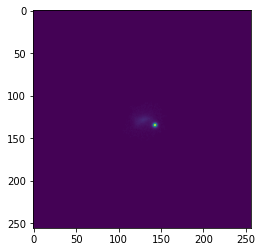

In [257]:
plt.imshow(get_image_data('66','original_image'))

/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


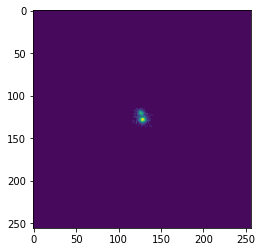

In [254]:
imgs = []

for i in image_dataset.index[:50]:
    if np.isnan(get_image_data(i,'original_image')).any():
        pass
    else:
        imgs.append(get_image_data(i,'original_image'))
    

In [251]:
for x in imgs:
    plt.imshow(imgs[x])

TypeError: only integer scalar arrays can be converted to a scalar index